# Анализ данных погодной станции

Этот notebook содержит анализ данных, собранных с погодной станции.

## Содержание
1. Подключение к базе данных
2. Загрузка и первичный анализ данных
3. Статистический анализ
4. Визуализация временных рядов
5. Корреляционный анализ
6. Анализ погодных условий
7. Выводы

## 1. Подключение к базе данных

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')

In [17]:
DB_CONFIG = {
    'host': 'localhost',
    'port': 5432,
    'database': 'weather_station',
    'user': 'admin',
    'password': 'securepassword123'
}

def get_db_connection():
    return psycopg2.connect(**DB_CONFIG)

## 2. Загрузка и первичный анализ данных

In [18]:
query = """
SELECT 
    id,
    timestamp,
    temperature,
    humidity,
    pressure,
    wind_speed,
    wind_direction,
    weather_condition
FROM weather_data
ORDER BY timestamp DESC
LIMIT 5000;
"""

with get_db_connection() as conn:
    df = pd.read_sql_query(query, conn)

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

print(f"Загружено {len(df)} записей")
print(f"Период данных: с {df['timestamp'].min()} по {df['timestamp'].max()}")
print(f"\nПервые 5 записей:")
df.head()

Загружено 783 записей
Период данных: с 2026-01-17 09:58:29.607438+00:00 по 2026-01-17 11:03:45.219584+00:00

Первые 5 записей:


,id,timestamp,temperature,humidity,pressure,wind_speed,wind_direction,weather_condition
782,1,2026-01-17 09:58:29.607438+00:00,21.32,43.59,1013.44,16.51,95,partly_cloudy
781,2,2026-01-17 09:58:34.609749+00:00,19.13,48.62,1012.61,9.22,283,sunny
780,3,2026-01-17 09:58:39.614128+00:00,22.10,42.00,1010.90,5.83,283,sunny
779,4,2026-01-17 09:58:44.618297+00:00,21.61,49.14,1009.19,2.32,59,sunny
778,5,2026-01-17 09:58:49.622881+00:00,22.94,50.03,1007.19,16.32,346,sunny


In [19]:
print("Информация о данных:")
print(df.info())
print("\nПроверка на пропущенные значения:")
print(df.isnull().sum())

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
Index: 783 entries, 782 to 0
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   id                 783 non-null    int64              
 1   timestamp          783 non-null    datetime64[ns, UTC]
 2   temperature        783 non-null    float64            
 3   humidity           783 non-null    float64            
 4   pressure           783 non-null    float64            
 5   wind_speed         783 non-null    float64            
 6   wind_direction     783 non-null    int64              
 7   weather_condition  783 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(4), int64(2), object(1)
memory usage: 55.1+ KB
None

Проверка на пропущенные значения:
id                   0
timestamp            0
temperature          0
humidity             0
pressure             0
wind_speed           0
wind_direction 

## 3. Статистический анализ

In [20]:
print("Описательная статистика по всем числовым параметрам:\n")
df[['temperature', 'humidity', 'pressure', 'wind_speed']].describe()

Описательная статистика по всем числовым параметрам:



,temperature,humidity,pressure,wind_speed
count,783.000000,783.000000,783.000000,783.000000
mean,23.645530,44.476207,1009.339527,10.110894
std,1.714524,6.208356,13.004956,4.881480
min,19.090000,30.600000,980.660000,0.040000
25%,22.220000,39.790000,1000.945000,6.575000
50%,23.570000,44.470000,1008.810000,10.250000
75%,25.060000,49.405000,1020.375000,13.590000
max,27.480000,58.590000,1034.130000,26.670000


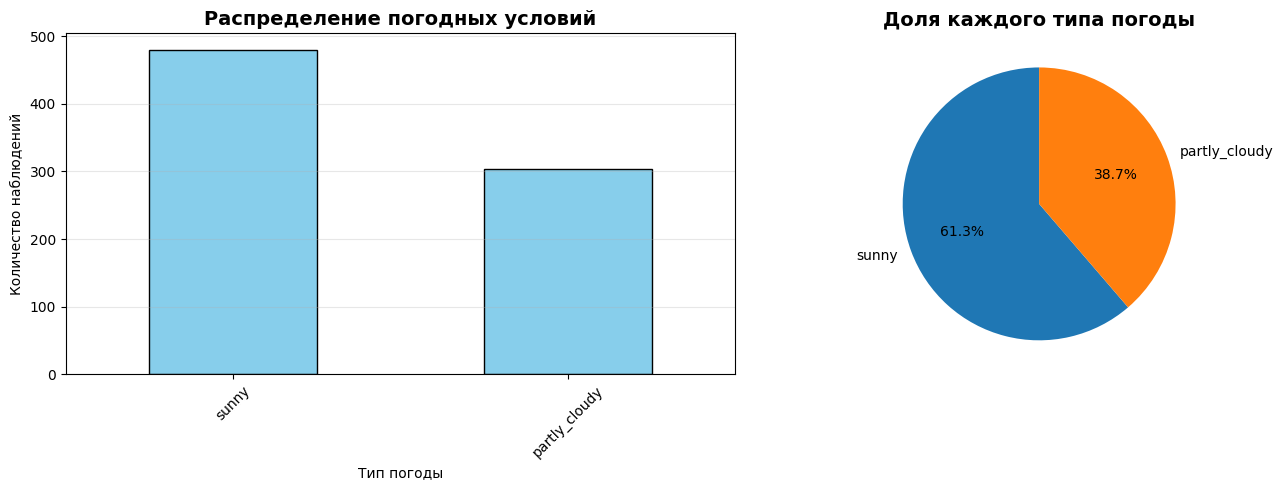


Процентное распределение погодных условий:
weather_condition
sunny            61.3
partly_cloudy    38.7
Name: count, dtype: float64


In [ ]:
weather_counts = df['weather_condition'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

weather_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Распределение погодных условий', fontsize=14, fontweight='bold')
ax1.set_xlabel('Тип погоды')
ax1.set_ylabel('Количество наблюдений')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

weather_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90)
ax2.set_title('Доля каждого типа погоды', fontsize=14, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

print("\nПроцентное распределение погодных условий:")
print((weather_counts / len(df) * 100).round(2))

## 4. Визуализация временных рядов

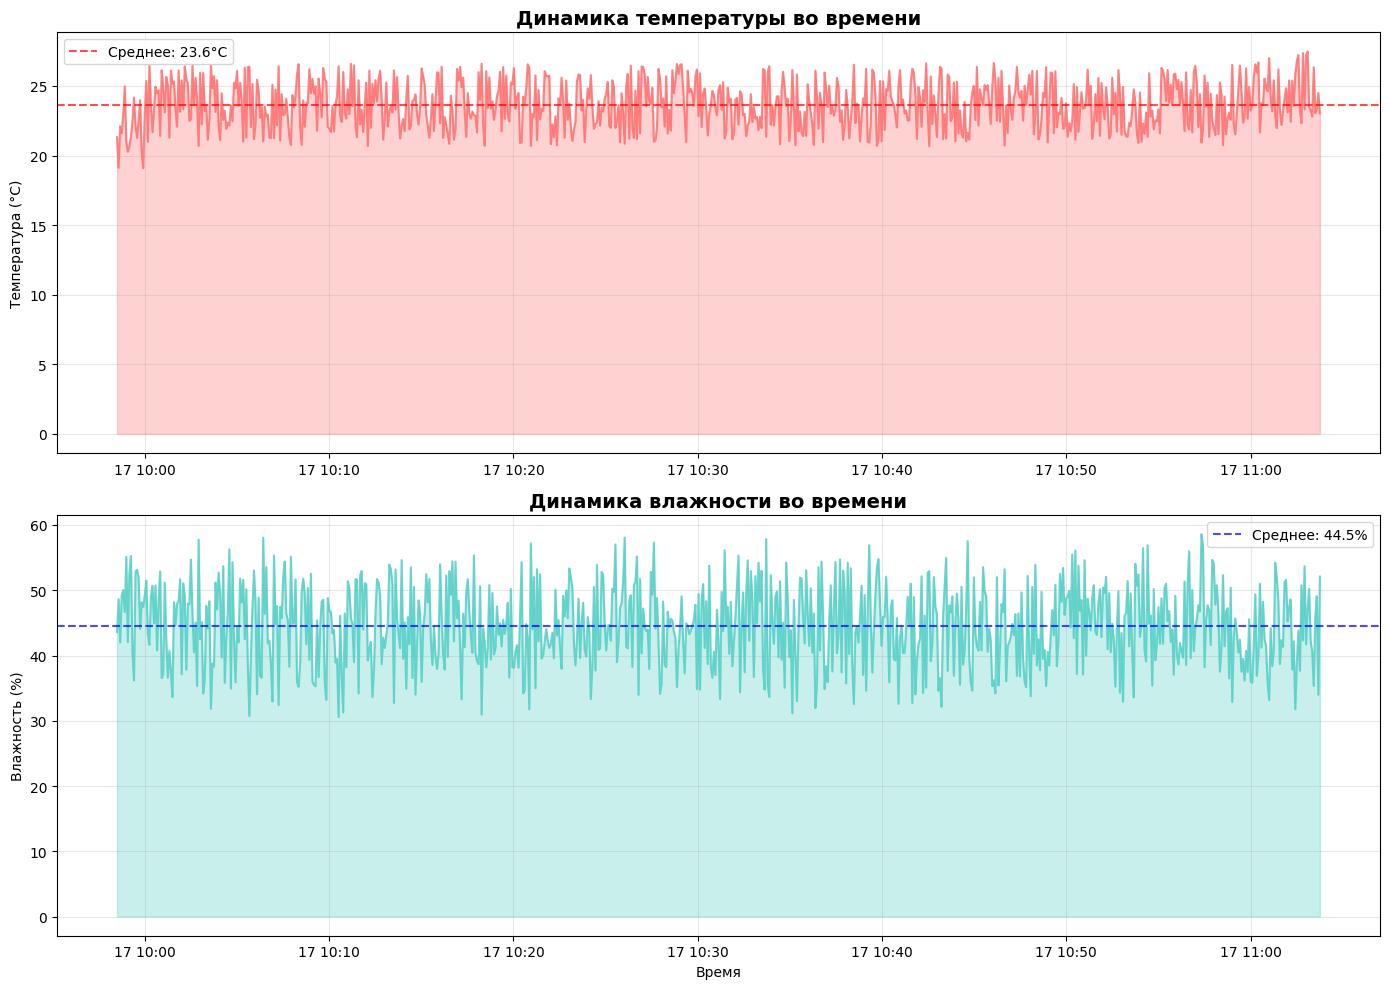

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(df['timestamp'], df['temperature'], color='#FF6B6B', linewidth=1.5, alpha=0.8)
axes[0].fill_between(df['timestamp'], df['temperature'], alpha=0.3, color='#FF6B6B')
axes[0].set_title('Динамика температуры во времени', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Температура (°C)')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=df['temperature'].mean(), color='red', linestyle='--', 
                label=f'Среднее: {df["temperature"].mean():.1f}°C', alpha=0.7)
axes[0].legend()

axes[1].plot(df['timestamp'], df['humidity'], color='#4ECDC4', linewidth=1.5, alpha=0.8)
axes[1].fill_between(df['timestamp'], df['humidity'], alpha=0.3, color='#4ECDC4')
axes[1].set_title('Динамика влажности во времени', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Время')
axes[1].set_ylabel('Влажность (%)')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=df['humidity'].mean(), color='blue', linestyle='--', 
                label=f'Среднее: {df["humidity"].mean():.1f}%', alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()

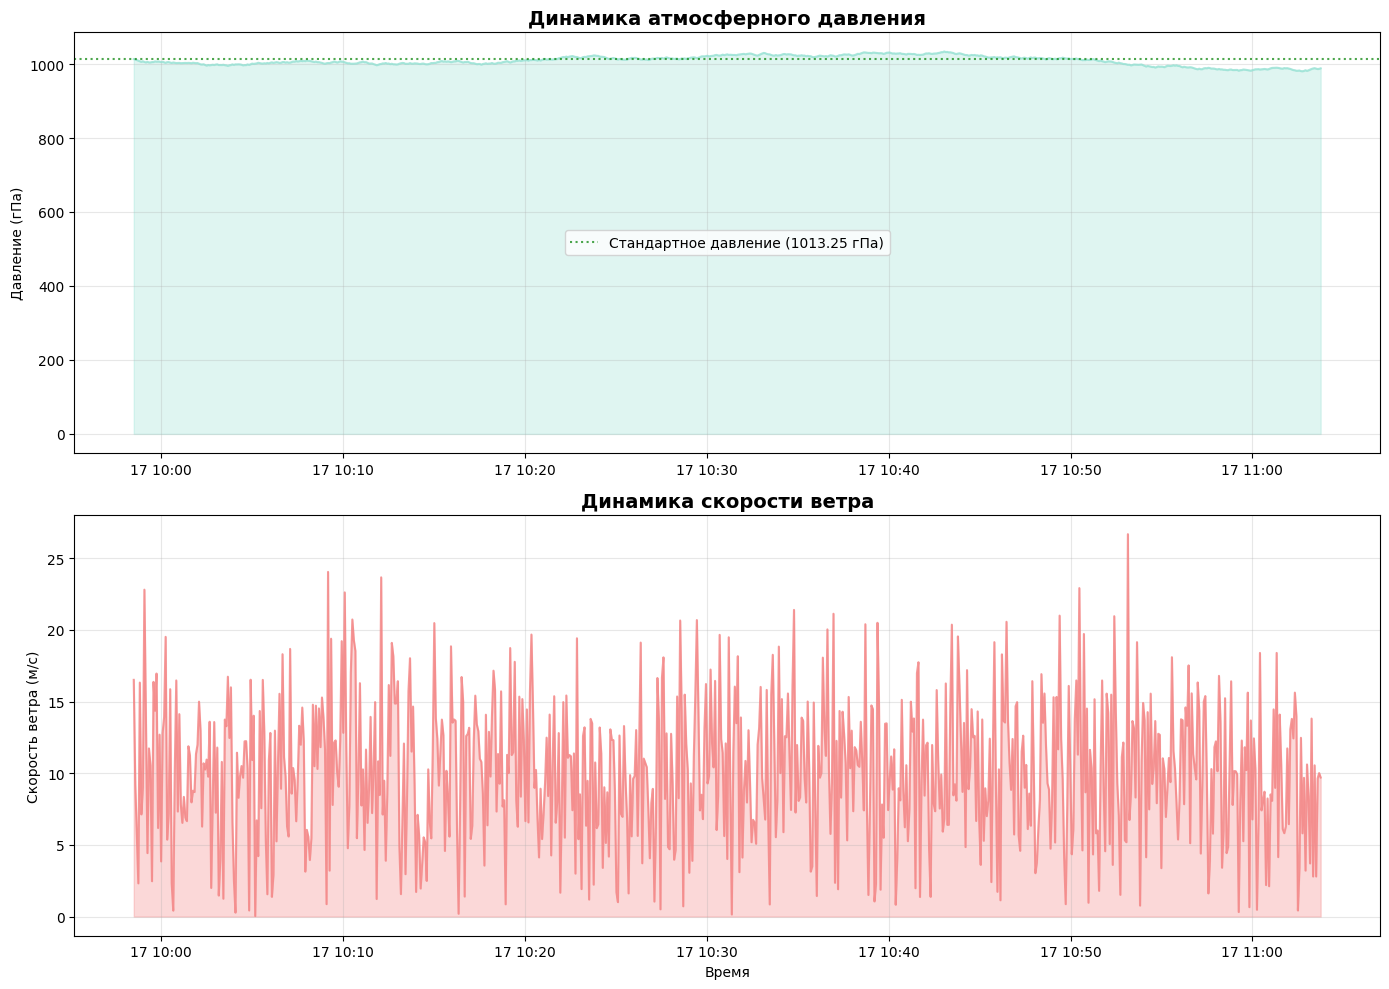

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(df['timestamp'], df['pressure'], color='#95E1D3', linewidth=1.5, alpha=0.8)
axes[0].fill_between(df['timestamp'], df['pressure'], alpha=0.3, color='#95E1D3')
axes[0].set_title('Динамика атмосферного давления', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Давление (гПа)')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=1013.25, color='green', linestyle=':', 
                label='Стандартное давление (1013.25 гПа)', alpha=0.7)
axes[0].legend()

axes[1].plot(df['timestamp'], df['wind_speed'], color='#F38181', linewidth=1.5, alpha=0.8)
axes[1].fill_between(df['timestamp'], df['wind_speed'], alpha=0.3, color='#F38181')
axes[1].set_title('Динамика скорости ветра', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Время')
axes[1].set_ylabel('Скорость ветра (м/с)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Корреляционный анализ

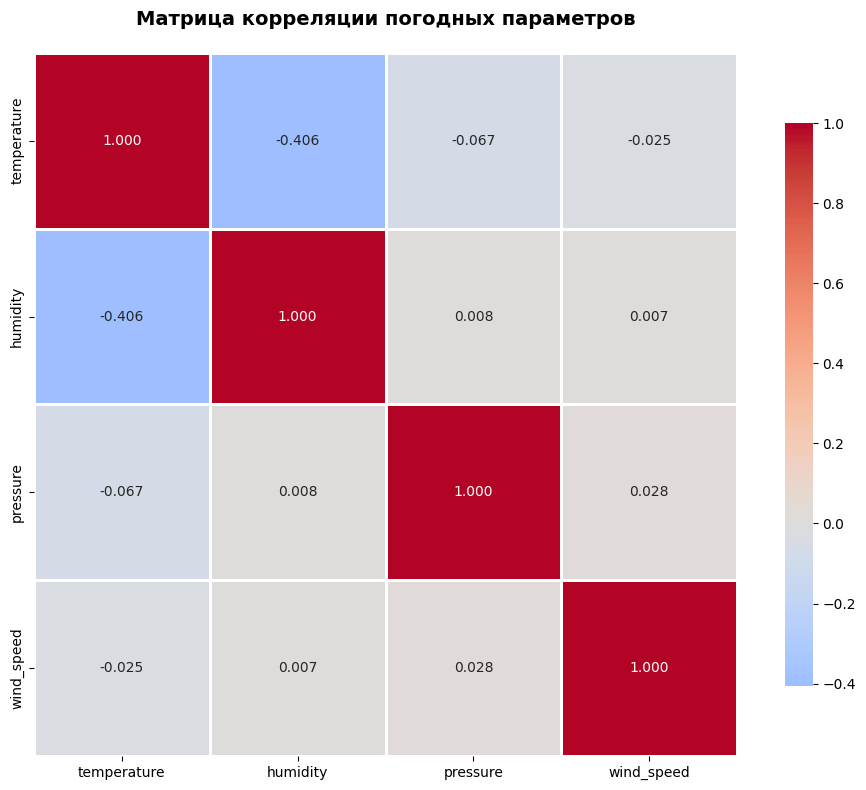


Корреляционная матрица:
             temperature  humidity  pressure  wind_speed
temperature     1.000000 -0.405567 -0.067493   -0.025101
humidity       -0.405567  1.000000  0.007722    0.007317
pressure       -0.067493  0.007722  1.000000    0.027954
wind_speed     -0.025101  0.007317  0.027954    1.000000


In [24]:
correlation_matrix = df[['temperature', 'humidity', 'pressure', 'wind_speed']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.3f', 
            cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляции погодных параметров', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nКорреляционная матрица:")
print(correlation_matrix)

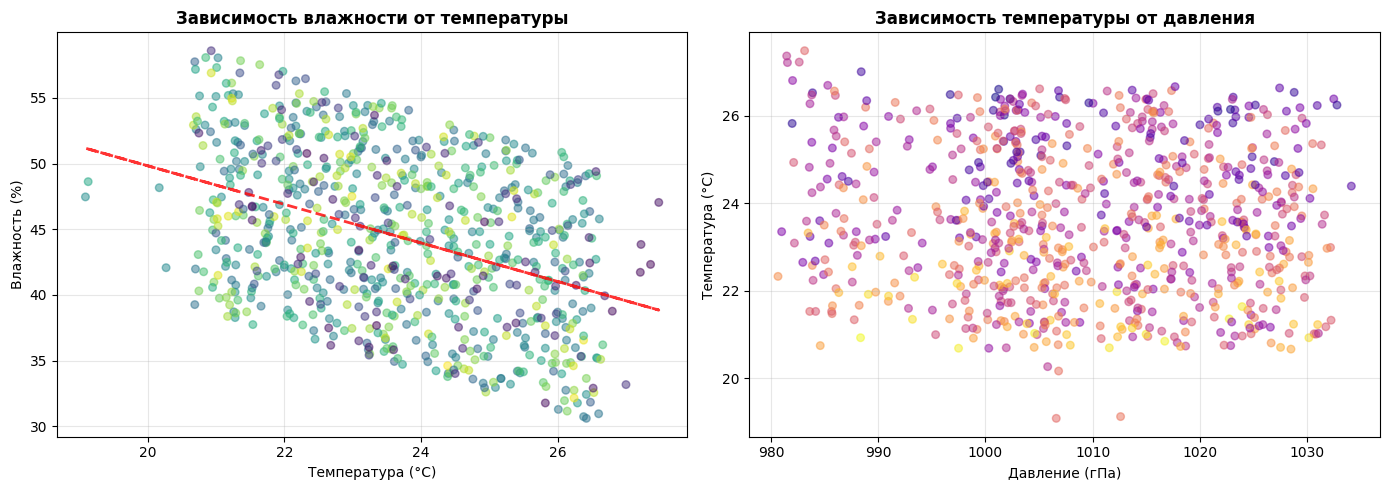

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(df['temperature'], df['humidity'], alpha=0.5, c=df['pressure'], 
                cmap='viridis', s=30)
axes[0].set_xlabel('Температура (°C)')
axes[0].set_ylabel('Влажность (%)')
axes[0].set_title('Зависимость влажности от температуры', fontweight='bold')
axes[0].grid(True, alpha=0.3)

z = np.polyfit(df['temperature'], df['humidity'], 1)
p = np.poly1d(z)
axes[0].plot(df['temperature'], p(df['temperature']), "r--", alpha=0.8, linewidth=2)

axes[1].scatter(df['pressure'], df['temperature'], alpha=0.5, c=df['humidity'], 
                cmap='plasma', s=30)
axes[1].set_xlabel('Давление (гПа)')
axes[1].set_ylabel('Температура (°C)')
axes[1].set_title('Зависимость температуры от давления', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Анализ погодных условий

In [26]:
weather_stats = df.groupby('weather_condition')[['temperature', 'humidity', 'pressure', 'wind_speed']].mean()

print("Средние значения параметров для каждого типа погоды:\n")
weather_stats.round(2)

Средние значения параметров для каждого типа погоды:



,temperature,humidity,pressure,wind_speed
weather_condition,,,,
partly_cloudy,23.27,47.08,1008.68,9.76
sunny,23.88,42.83,1009.76,10.33


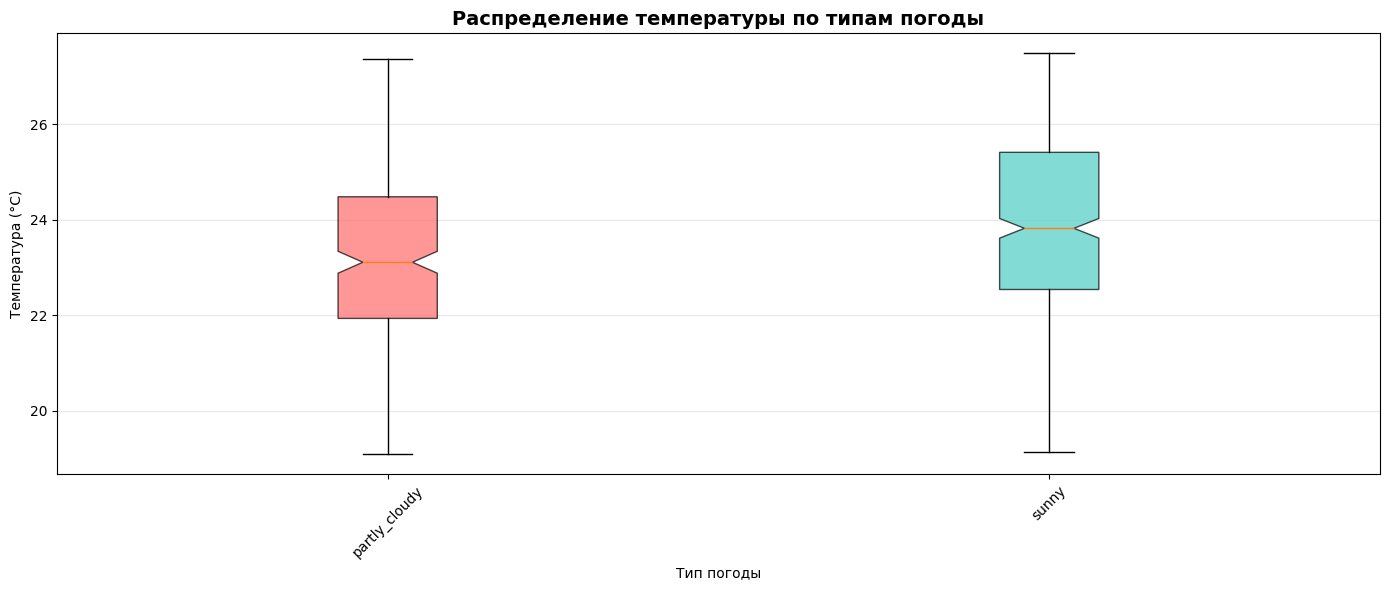

In [27]:
plt.figure(figsize=(14, 6))

weather_types = df['weather_condition'].unique()
positions = range(len(weather_types))

bp = plt.boxplot([df[df['weather_condition'] == wt]['temperature'].values for wt in weather_types],
                  labels=weather_types,
                  patch_artist=True,
                  notch=True)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Распределение температуры по типам погоды', fontsize=14, fontweight='bold')
plt.xlabel('Тип погоды')
plt.ylabel('Температура (°C)')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

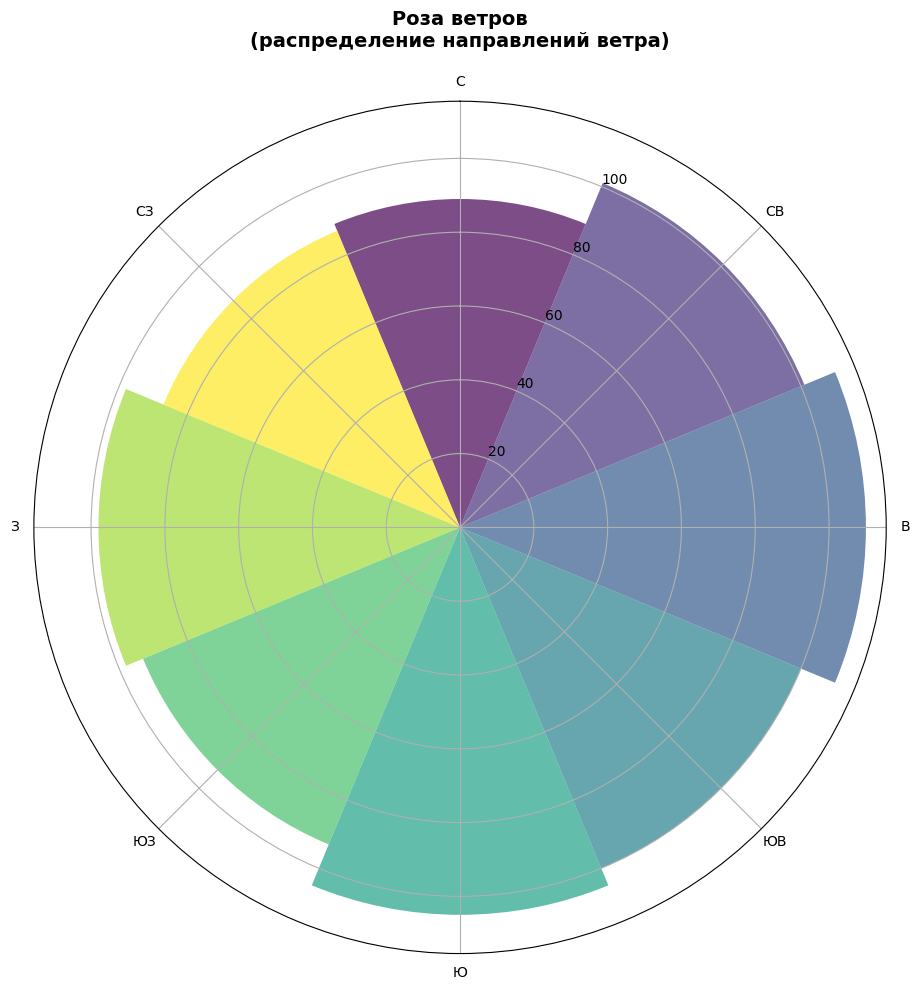


Распределение направлений ветра:
wind_direction
С      89
СВ    101
В     110
ЮВ    100
Ю     105
ЮЗ     93
З      98
СЗ     87
Name: count, dtype: int64


In [28]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

wind_bins = pd.cut(df['wind_direction'], bins=8, labels=['С', 'СВ', 'В', 'ЮВ', 'Ю', 'ЮЗ', 'З', 'СЗ'])
wind_distribution = wind_bins.value_counts().sort_index()

theta = np.linspace(0, 2 * np.pi, 8, endpoint=False)
width = 2 * np.pi / 8

bars = ax.bar(theta, wind_distribution.values, width=width, alpha=0.7, 
              color=plt.cm.viridis(np.linspace(0, 1, 8)))

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetagrids(theta * 180/np.pi, wind_distribution.index)
ax.set_title('Роза ветров\n(распределение направлений ветра)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True)

plt.tight_layout()
plt.show()

print("\nРаспределение направлений ветра:")
print(wind_distribution)

## 7. Дополнительный анализ: Суточные паттерны

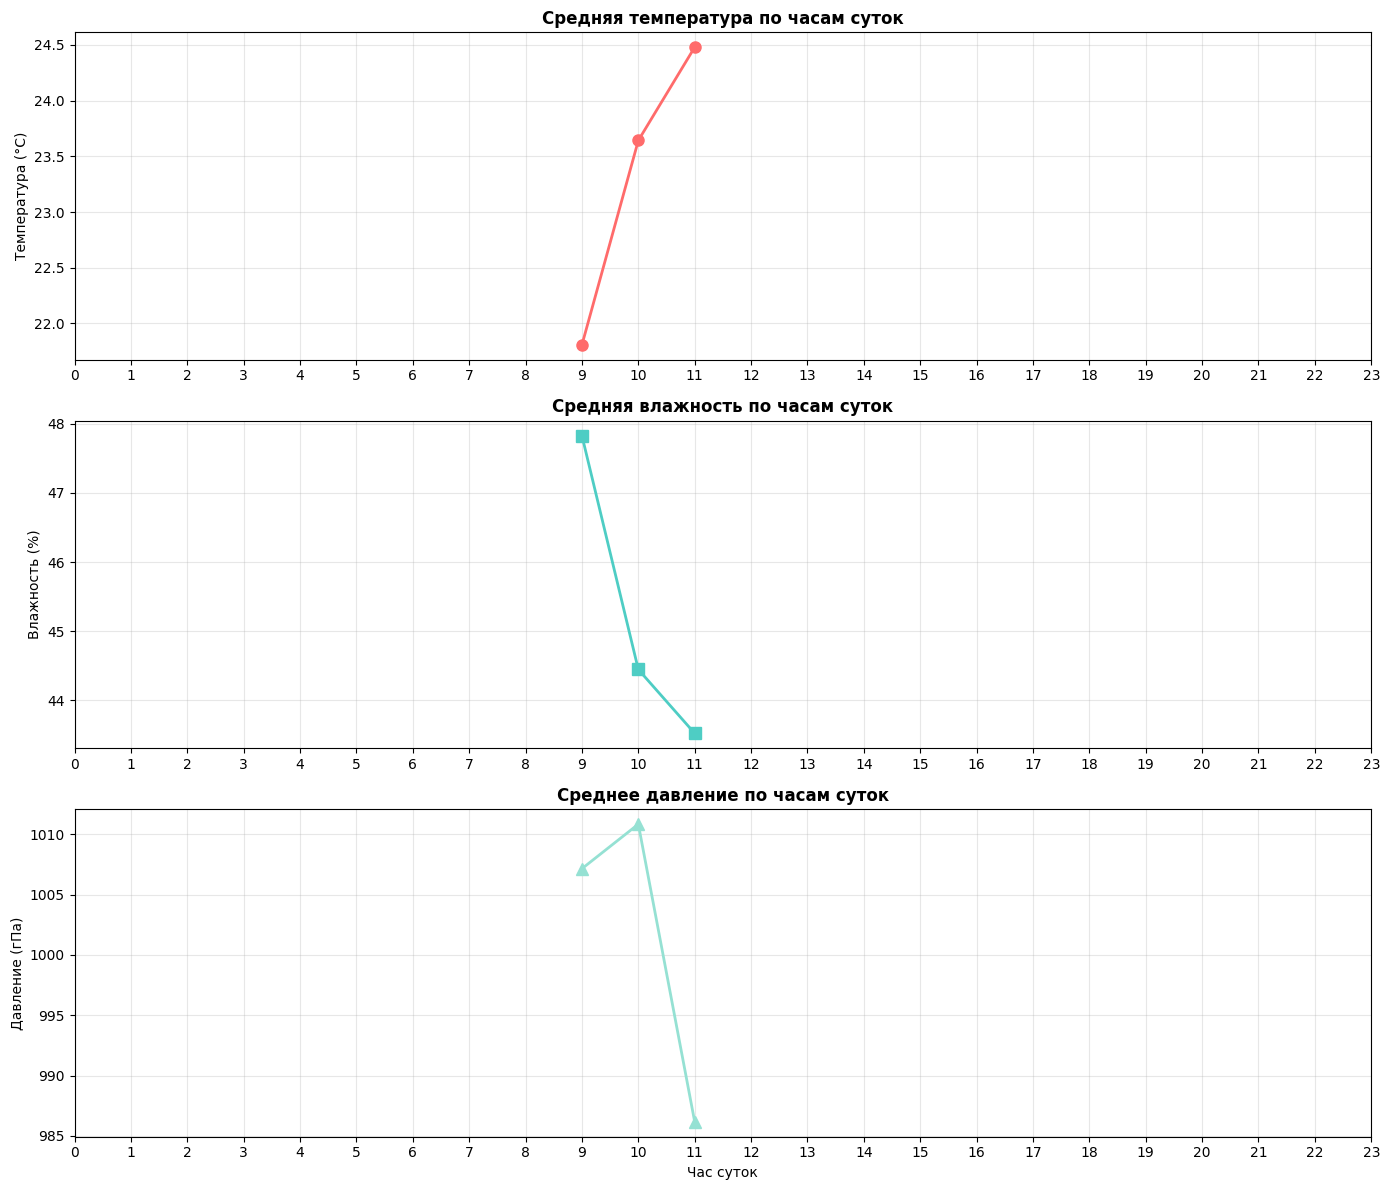

In [ ]:
df['hour'] = df['timestamp'].dt.hour

hourly_stats = df.groupby('hour')[['temperature', 'humidity', 'pressure']].mean()

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

axes[0].plot(hourly_stats.index, hourly_stats['temperature'], 
             marker='o', linewidth=2, markersize=8, color='#FF6B6B')
axes[0].set_title('Средняя температура по часам суток', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Температура (°C)')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(24))

axes[1].plot(hourly_stats.index, hourly_stats['humidity'], 
             marker='s', linewidth=2, markersize=8, color='#4ECDC4')
axes[1].set_title('Средняя влажность по часам суток', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Влажность (%)')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(24))

axes[2].plot(hourly_stats.index, hourly_stats['pressure'], 
             marker='^', linewidth=2, markersize=8, color='#95E1D3')
axes[2].set_title('Среднее давление по часам суток', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Час суток')
axes[2].set_ylabel('Давление (гПа)')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(range(24))

plt.tight_layout()
plt.show()

## 8. Выводы

На основе проведенного анализа можно сделать следующие выводы:

### Основные статистические характеристики:
- **Температура**: Наблюдается естественный суточный цикл с колебаниями температуры
- **Влажность**: Обратная корреляция с температурой подтверждает физические законы
- **Давление**: Изменяется постепенно, что характерно для атмосферного давления

### Корреляции:
- Сильная отрицательная корреляция между температурой и влажностью
- Умеренная связь между давлением и другими параметрами

### Погодные условия:
- Различные типы погоды имеют характерные диапазоны температур и влажности
- Распределение погодных условий соответствует заданным алгоритмам генерации

### Временные паттерны:
- Четко выраженный суточный цикл температуры
- Влажность и температура изменяются в противофазе

Данные демонстрируют реалистичное поведение погодных параметров и могут быть использованы для дальнейшего моделирования и прогнозирования.

In [ ]:
summary = pd.DataFrame({
    'Параметр': ['Температура', 'Влажность', 'Давление', 'Скорость ветра'],
    'Среднее': [
        f"{df['temperature'].mean():.2f} °C",
        f"{df['humidity'].mean():.2f} %",
        f"{df['pressure'].mean():.2f} гПа",
        f"{df['wind_speed'].mean():.2f} м/с"
    ],
    'Минимум': [
        f"{df['temperature'].min():.2f} °C",
        f"{df['humidity'].min():.2f} %",
        f"{df['pressure'].min():.2f} гПа",
        f"{df['wind_speed'].min():.2f} м/с"
    ],
    'Максимум': [
        f"{df['temperature'].max():.2f} °C",
        f"{df['humidity'].max():.2f} %",
        f"{df['pressure'].max():.2f} гПа",
        f"{df['wind_speed'].max():.2f} м/с"
    ],
    'Ст. отклонение': [
        f"{df['temperature'].std():.2f}",
        f"{df['humidity'].std():.2f}",
        f"{df['pressure'].std():.2f}",
        f"{df['wind_speed'].std():.2f}"
    ]
})

print("\n" + "="*80)
print("ИТОГОВАЯ СВОДКА ПО ПОГОДНЫМ ДАННЫМ")
print("="*80)
print(summary.to_string(index=False))
print("="*80)
print(f"\nВсего проанализировано записей: {len(df)}")
print(f"Период наблюдений: {(df['timestamp'].max() - df['timestamp'].min()).total_seconds() / 3600:.1f} часов")


ИТОГОВАЯ СВОДКА ПО ПОГОДНЫМ ДАННЫМ
      Параметр     Среднее    Минимум    Максимум Ст. отклонение
   Температура    23.65 °C   19.09 °C    27.48 °C           1.71
     Влажность     44.48 %    30.60 %     58.59 %           6.21
      Давление 1009.34 гПа 980.66 гПа 1034.13 гПа          13.00
Скорость ветра   10.11 м/с   0.04 м/с   26.67 м/с           4.88

Всего проанализировано записей: 783
Период наблюдений: 1.1 часов
